<a href="https://githubtocolab.com/gee-community/geemap/blob/master/examples/notebooks/140_ee_to_xarray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

**Converting Earth Engine images to an Xarray Dataset**

This notebook demonstrates how to convert Earth Engine images to an Xarray Dataset using [xee](https://github.com/google/Xee).

In [320]:
#!pip install -U geemap
#!pip install PyCRS
!pip install eemont

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.7/134.7 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.7/224.7 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eemont: filename=eemont-0.3.6-py3-none-any.whl size=135742 sha256=bf0358fed83ae7d32189d5b599de281f93e6b8a3e59d55e3bc66c5c418b0cc8c
  Stored in directory: /root/.cache/pip/wheels/c2/79/2c/4fed17c3d3b466bbf4fe5872eec11f189147043b01152a4f75
  Created wheel for ee_extra: filename=ee_extra-0.0.15-py3-none-any.whl size=236757 sha256=fe87807f5e15bfff912e3859d5df5604135b79433b09e26c1b1834e9fb5f438a
  Stored in directory: /root/.cache/pip/wheels/29/96/0e/4e36b0dfd85e16867723df739294c0aa45a65b191adac4d959
Successfully built eemont ee_extra


In [332]:
import ee
import geemap
import sys
import pycrs

import xarray
import glob
import matplotlib.pyplot as plt
import datetime

import eemont
import pandas as pd

In [4]:
#geemap.ee_initialize()

try:
    ee.Authenticate()
    ee.Initialize(project='ee-gabibessel')
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

In [396]:
#
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
Map = geemap.Map(toolbar_ctrl=True, layer_ctrl=True)
Map.default_style = {'cursor': 'crosshair'}
Map.add_basemap('SATELLITE')

# Center the map in the desired country
country = 'Spain'
country_bounds = ee.FeatureCollection("USDOS/LSIB_SIMPLE/2017").filterMetadata('country_na', 'equals', country);
Map.centerObject(country_bounds,8)
Map

Map(center=[40.35722509547827, -3.499564837147696], controls=(WidgetControl(options=['position', 'transparent_…

In [7]:
!rm -r RESSBIO # delete the complete repository folder
!git clone https://github.com/Grcf2585/RESSBIO # clone repository folder
sys.path.insert(0,'/content/RESSBIO')

rm: cannot remove 'RESSBIO': No such file or directory
Cloning into 'RESSBIO'...
remote: Enumerating objects: 399, done.
remote: Counting objects: 100% (137/137), done.
remote: Compressing objects: 100% (108/108), done.
remote: Total 399 (delta 86), reused 28 (delta 28), pack-reused 262
Receiving objects: 100% (399/399), 50.26 MiB | 14.47 MiB/s, done.
Resolving deltas: 100% (216/216), done.


In [8]:
roi_Bellus = geemap.shp_to_ee('/content/RESSBIO/Vectorial/Bellus.shp')
Map.addLayer(roi_Bellus, {},'Bellus ROI',True)

In [12]:
study_roi = Map.draw_last_feature

In [424]:
# Define the path to your CSV file
csv_path = '/content/drive/MyDrive/RESSBIO_Bellus_collections/Bellus_sampling_points.csv'

# Read the CSV file using pandas
points_data = pd.read_csv(csv_path)

# Create a list of geometry points from latitude and longitude columns
geometry_list = list(zip(points_data['lon'], points_data['lat']))  # Assuming 'lon' is longitude

# Create an empty FeatureCollection
points_collection = ee.FeatureCollection([])

# Add each geometry point to the FeatureCollection
for point in geometry_list:
  points_collection = points_collection.merge(ee.Feature(ee.Geometry.Point(point[0], point[1])))  # (lon, lat) order

# Set visualization parameters for points (optional)
point_style = {'color': 'red', 'size': 10}

# Add the points layer to the map
Map.addLayer(points_collection, point_style, "Points from CSV")

In [14]:
# Define your study region as a GeoJSON feature or feature collection
region = ee.FeatureCollection(study_roi)

In [334]:
#
d1='2023-01-01'
d2= '2022-12-16'

# Define a dictionary containing sampling points and dates
sampling_points = {
    "point1": {"lat": -34.6037, "lon": -58.3772, "date": d1},
    "point2": {"lat": 41.8899, "lon": 12.4923, "date": d2},
}
sampling_points

{'point1': {'lat': -34.6037, 'lon': -58.3772, 'date': '2023-01-01'},
 'point2': {'lat': 41.8899, 'lon': 12.4923, 'date': '2022-12-16'}}

In [408]:
sampling_points_df = pd.read_csv('/content/drive/MyDrive/RESSBIO_Bellus_collections/Bellus_sampling_points.csv')

# Convert the DataFrame to a Dictionary
sampling_points_dict = sampling_points_df.to_dict(orient='records')

In [409]:
# Function to extract reflectance at a point and date
def get_reflectance(point, date,delta_time):

  ################################################################
  # Convert sampling point to a geometry point
  point_geometry = ee.Geometry.Point([point["lon"], point["lat"]])

  ################################################################
  # Define date as a filter for Sentinel-2 L2A images
  # Define a date range for filtering (delta_time days before and after)

  max_date =  datetime.datetime.strptime(date, "%Y-%m-%d") + datetime.timedelta(days=delta_time)
  min_date =  datetime.datetime.strptime(date, "%Y-%m-%d") + datetime.timedelta(days=-delta_time)
  dateRange = ee.DateRange(min_date, max_date)
  date_filter = ee.Filter.date(dateRange)

  ###################################################################
  # Filter the Sentinel-2 L2A image collection within the date range
  s2_collection = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED") \
      .filter(date_filter) \
      .filterBounds(point_geometry)\
      .closest(date)

  ###################################
  # Check if any images are available
  if s2_collection.size().getInfo() > 0:
    # Get the first image (assuming one image per overpass)
    sentinel2_image = s2_collection.first()
    #sentinel2_image = s2_collection.closest(date)

    ##########################################
    # Extract reflectance values for all bands
    reflectance = sentinel2_image.select('B[1-9]').divide(10000).reduceRegion(
        reducer=ee.Reducer.mean(), geometry=point_geometry)

    ####################################################################
    # Calculate difference in days between acquisition and sampling date
    acquisition_date = sentinel2_image.get('system:time_start')
    date_diff = ee.Date(date).difference(ee.Date(acquisition_date), 'days')

    ###################################
    # Create a dictionary with results
    return {
        "lon": point["lon"],
        "lat": point["lat"],
        "Sampling_date": date,
        "S2_date": sentinel2_image.get('system:index').getInfo()[0:8],
        "days_diff": round(ee.Number(date_diff).abs().getInfo(),0),
        "S2_product_ID":sentinel2_image.get('PRODUCT_ID').getInfo(),
        **reflectance.getInfo()  # Extract all reflectance band values
    }
  else:
    # No image found, return an empty dictionary
    return {
        "lon": point["lon"],
        "lat": point["lat"],
        "Sampling_date": date,
    }

In [418]:
# Function to extract reflectance at a point and date
def get_reflectance(point, date,delta_time):

  ################################################################
  # Convert sampling point to a geometry point
  point_geometry = ee.Geometry.Point([point["lon"], point["lat"]])

  ################################################################
  # Define date as a filter for Sentinel-2 L2A images
  # Define a date range for filtering (delta_time days before and after)

  max_date =  datetime.datetime.strptime(date, "%Y-%m-%d") + datetime.timedelta(days=delta_time)
  min_date =  datetime.datetime.strptime(date, "%Y-%m-%d") + datetime.timedelta(days=-delta_time)
  dateRange = ee.DateRange(min_date, max_date)
  date_filter = ee.Filter.date(dateRange)

  ###################################################################
  # Filter the Sentinel-2 L2A image collection within the date range
  s2_collection = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED") \
      .filter(date_filter) \
      .filterBounds(point_geometry)\
      .closest(date)

  ###################################
  # Check if any images are available
  if s2_collection.size().getInfo() > 0:
    # Get the first image (assuming one image per overpass)
    sentinel2_image = s2_collection.first()

    ##########################################
    # Extract reflectance values for all bands
    reflectance = sentinel2_image.select(['B1','B2', 'B3', 'B4', 'B5', 'B6', 'B7','B8','B8A','B9','B11','B12']).divide(10000).reduceRegion(
        reducer=ee.Reducer.mean(), geometry=point_geometry)

    metadata = sentinel2_image.select(['SCL','MSK_CLDPRB','QA60']).reduceRegion(
        reducer=ee.Reducer.mean(), geometry=point_geometry)

    ####################################################################
    # Calculate difference in days between acquisition and sampling date
    acquisition_date = sentinel2_image.get('system:time_start')
    date_diff = ee.Date(date).difference(ee.Date(acquisition_date), 'days')

    ###################################
    # Create a dictionary with results
    return {
        "ID_point": point["Name"],
        "lon": point["lon"],
        "lat": point["lat"],
        "Sampling_date": date,
        "S2_date": sentinel2_image.get('system:index').getInfo()[0:8],
        "days_diff": round(ee.Number(date_diff).abs().getInfo(),0),
        "S2_product_ID":sentinel2_image.get('PRODUCT_ID').getInfo(),
        "S2_CPP":sentinel2_image.get('CLOUDY_PIXEL_PERCENTAGE').getInfo(),
        **reflectance.getInfo(),  # Extract all reflectance band values
        **metadata.getInfo()
    }
  else:
    # No image found, return an empty dictionary
    return {
        "ID_point": point["Name"],
        "lon": point["lon"],
        "lat": point["lat"],
        "Sampling_date": date,
    }

In [419]:
# Loop through sampling points and dates, call the function
delta = 3
S2_L2A_reflectance = []
for point_data in sampling_points_dict:
  result = get_reflectance(point_data, point_data['date'],delta)
  if result:
    S2_L2A_reflectance.append(result)

In [420]:
S2_L2A_reflectance_df = pd.DataFrame.from_dict(S2_L2A_reflectance,orient='columns')
S2_L2A_reflectance_df

,ID_point,lon,lat,Sampling_date,S2_date,days_diff,S2_product_ID,S2_CPP,B1,B11,...,B4,B5,B6,B7,B8,B8A,B9,MSK_CLDPRB,QA60,SCL
0,BL170615_P1,-0.474777,38.934813,2017-06-15,20170615,0.0,S2A_MSIL2A_20170615T105031_N0205_R051_T30SYJ_2...,0.000000,0.0855,0.0618,...,0.0904,0.1201,0.0619,0.0587,0.0608,0.0471,0.0367,NaN,0,7
1,BL170615_P2,-0.469936,38.931140,2017-06-15,20170615,0.0,S2A_MSIL2A_20170615T105031_N0205_R051_T30SYJ_2...,0.000000,0.0719,0.0482,...,0.0746,0.1020,0.0452,0.0454,0.0445,0.0364,0.0239,NaN,0,2
2,BL170615_P3,-0.475095,38.928143,2017-06-15,20170615,0.0,S2A_MSIL2A_20170615T105031_N0205_R051_T30SYJ_2...,0.000000,0.0652,0.0420,...,0.0744,0.0996,0.0474,0.0452,0.0416,0.0361,0.0191,NaN,0,2
3,BL180322_P1,-0.477221,38.934226,2018-03-22,20180322,0.0,S2A_MSIL2A_20180322T105021_N0206_R051_T30SYJ_2...,0.131200,0.0279,0.0046,...,0.0355,0.0811,0.0257,0.0247,0.0178,0.0093,0.0001,NaN,0,6
4,BL180322_P2,-0.476744,38.932702,2018-03-22,20180322,0.0,S2A_MSIL2A_20180322T105021_N0206_R051_T30SYJ_2...,0.131200,0.0223,0.0043,...,0.0307,0.0729,0.0238,0.0218,0.0162,0.0064,0.0001,NaN,0,6
5,BL180322_P3,-0.472942,38.928989,2018-03-22,20180322,0.0,S2A_MSIL2A_20180322T105021_N0206_R051_T30SYJ_2...,0.131200,0.0248,0.0026,...,0.0328,0.0759,0.0248,0.0220,0.0168,0.0076,0.0001,NaN,0,6
6,BL200625_P1,-0.473796,38.930935,2020-06-25,20200624,1.0,S2B_MSIL2A_20200624T104629_N0214_R051_T30SYJ_2...,50.521366,0.1053,0.0892,...,0.1094,0.1316,0.1238,0.1260,0.1070,0.1219,0.2434,7.0,2048,10
7,BL200625_P2,-0.471977,38.931175,2020-06-25,20200624,1.0,S2B_MSIL2A_20200624T104629_N0214_R051_T30SYJ_2...,50.521366,0.0870,0.0738,...,0.0950,0.1120,0.0955,0.1009,0.0984,0.0949,0.1922,6.0,2048,10
8,BL200625_P3,-0.472548,38.930025,2020-06-25,20200624,1.0,S2B_MSIL2A_20200624T104629_N0214_R051_T30SYJ_2...,50.521366,0.0856,0.0705,...,0.0889,0.1097,0.0955,0.0979,0.0938,0.0915,0.1852,5.0,2048,10
9,BL200625_P4,-0.473381,38.928647,2020-06-25,20200624,1.0,S2B_MSIL2A_20200624T104629_N0214_R051_T30SYJ_2...,50.521366,0.0812,0.0644,...,0.0869,0.1032,0.0868,0.0922,0.0892,0.0869,0.1715,0.0,2048,10


In [414]:
# Loop through sampling points and dates, call the function
delta = 20
S2_L2A_reflectance = []
for point_name, point_data in sampling_points.items():
  result = get_reflectance(point_data, point_data["date"],delta)
  if result:
    S2_L2A_reflectance.append(result)

# Print the results (consider exporting to a CSV file for better handling)
print(S2_L2A_reflectance)

KeyError: 'Name'

In [403]:
S2_L2A_reflectance_df = pd.DataFrame.from_dict(S2_L2A_reflectance,orient='columns')
S2_L2A_reflectance_df

,lon,lat,Sampling_date,S2_date,days_diff,S2_product_ID,B1,B2,B3,B4,B5,B6,B7,B8,B9
0,-58.3772,-34.6037,2023-01-01,20221229,2.0,S2B_MSIL2A_20221229T134709_N0509_R024_T21HUB_2...,0.0990,0.1345,0.1503,0.1589,0.1708,0.1732,0.1734,0.1598,0.1489
1,12.4923,41.8899,2022-12-16,20221216,0.0,S2B_MSIL2A_20221216T100329_N0509_R122_T32TQM_2...,1.1519,1.1134,1.0723,1.0609,1.1034,1.0791,1.0674,1.1095,1.5004


In [404]:
s2_collection = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED") \
      .filterBounds(point_geometry)

sentinel2_image = s2_collection.first()
sentinel2_image.getInfo()


{'type': 'Image',
 'bands': [{'id': 'B1',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': 0,
    'max': 65535},
   'dimensions': [1830, 1830],
   'crs': 'EPSG:32721',
   'crs_transform': [60, 0, 300000, 0, -60, 6200020]},
  {'id': 'B2',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': 0,
    'max': 65535},
   'dimensions': [10980, 10980],
   'crs': 'EPSG:32721',
   'crs_transform': [10, 0, 300000, 0, -10, 6200020]},
  {'id': 'B3',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': 0,
    'max': 65535},
   'dimensions': [10980, 10980],
   'crs': 'EPSG:32721',
   'crs_transform': [10, 0, 300000, 0, -10, 6200020]},
  {'id': 'B4',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': 0,
    'max': 65535},
   'dimensions': [10980, 10980],
   'crs': 'EPSG:32721',
   'crs_transform': [10, 0, 300000, 0, -10, 6200020]},
  {'id': 'B5',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min':

In [293]:
sentinel2_image = s2_collection.first()
sentinel2_image.getInfo()

{'type': 'Image',
 'bands': [{'id': 'B1',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': 0,
    'max': 65535},
   'dimensions': [1830, 1830],
   'crs': 'EPSG:32721',
   'crs_transform': [60, 0, 300000, 0, -60, 6200020]},
  {'id': 'B2',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': 0,
    'max': 65535},
   'dimensions': [10980, 10980],
   'crs': 'EPSG:32721',
   'crs_transform': [10, 0, 300000, 0, -10, 6200020]},
  {'id': 'B3',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': 0,
    'max': 65535},
   'dimensions': [10980, 10980],
   'crs': 'EPSG:32721',
   'crs_transform': [10, 0, 300000, 0, -10, 6200020]},
  {'id': 'B4',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min': 0,
    'max': 65535},
   'dimensions': [10980, 10980],
   'crs': 'EPSG:32721',
   'crs_transform': [10, 0, 300000, 0, -10, 6200020]},
  {'id': 'B5',
   'data_type': {'type': 'PixelType',
    'precision': 'int',
    'min':

In [40]:
start_date = '2023-01-01'
end_date = '2023-12-31'
CLOUD_FILTER = 30

In [124]:
i = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED').filterBounds(roi_Bellus).filterDate(start_date, end_date).filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', CLOUD_FILTER))
ds = xarray.open_dataset(i, engine='ee')

In [125]:
geometry = ee.Geometry.Rectangle(-0.4366457028875175, 38.90208924666092,-0.4979814168160033, 38.94254011834727)

#geometry = ee.Geometry.Rectangle(-1,30,1,40)

In [126]:
ds = geemap.ee_to_xarray(i, crs="EPSG:25830", scale=10, geometry=geometry)
ds

<xarray.Dataset>
Dimensions:     (time: 87, X: 519, Y: 464)
Coordinates:
  * time        (time) datetime64[ns] 2023-01-05T11:00:13.939000 ... 2023-12-...
  * X           (X) float64 7.17e+05 7.17e+05 7.17e+05 ... 7.221e+05 7.222e+05
  * Y           (Y) float64 4.309e+06 4.309e+06 ... 4.314e+06 4.314e+06
Data variables: (12/23)
    B1          (time, X, Y) float32 ...
    B2          (time, X, Y) float32 ...
    B3          (time, X, Y) float32 ...
    B4          (time, X, Y) float32 ...
    B5          (time, X, Y) float32 ...
    B6          (time, X, Y) float32 ...
    ...          ...
    TCI_B       (time, X, Y) float32 ...
    MSK_CLDPRB  (time, X, Y) float32 ...
    MSK_SNWPRB  (time, X, Y) float32 ...
    QA10        (time, X, Y) float32 ...
    QA20        (time, X, Y) float32 ...
    QA60        (time, X, Y) float32 ...
Attributes: (12/18)
    date_range:             [1490659200000, 1647907200000]
    description:            <p>Sentinel-2 is a wide-swath, high-resolution, m...
    keywords:               ['copernicus', 'esa', 'eu', 'msi', 'reflectance',...
    period:                 0
    product_tags:           ['msi', 'sr', 'reflectance']
    provider:               European Union/ESA/Copernicus
    ...                     ...
    type_name:              ImageCollection
    visualization_0_bands:  B4,B3,B2
    visualization_0_max:    3000.0
    visualization_0_min:    0.0
    visualization_0_name:   RGB
    crs:                    EPSG:25830

<xarray.DataArray 'B4' (time: 87, X: 519, Y: 464)>
[20950992 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2023-01-05T11:00:13.939000 ... 2023-12-26T...
  * X        (X) float64 7.17e+05 7.17e+05 7.17e+05 ... 7.221e+05 7.222e+05
  * Y        (Y) float64 4.309e+06 4.309e+06 4.309e+06 ... 4.314e+06 4.314e+06
Attributes:
    id:             B4
    data_type:      {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max'...
    dimensions:     [10980, 10980]
    crs:            EPSG:25830
    crs_transform:  [10, 0, 699960, 0, -10, 4400040]

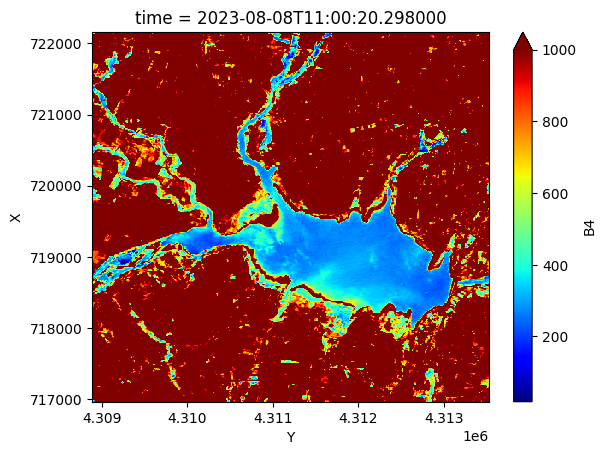

In [122]:
ds.B4[49,:,:].plot(cmap='jet', vmax=1000)
#plt.ylim(-0.4366457028875175,-0.4979814168160033)
#plt.xlim(38.90208924666092,38.94254011834727)
#plt.ylim(-2,2)
#plt.xlim(35,45)
ds.B4

In [128]:
ds.to_netcdf('/content/drive/saved_on_disk.nc')

EEException: Total request size (57016320 bytes) must be less than or equal to 50331648 bytes.

In [130]:
geemap.ee_export_image_to_drive(
     i.toBands(), description='S2_Bellus_collection', folder='RESSBIO_Bellus_collections', region=roi_Bellus.geometry(), scale=10
)

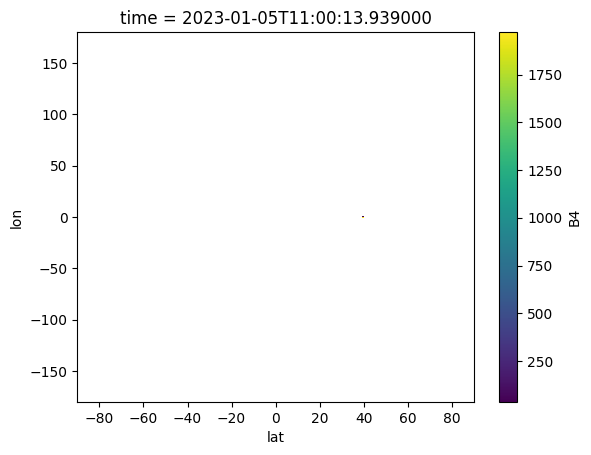

In [114]:
ds = geemap.ee_to_xarray(ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
        .filterBounds(roi_Bellus)
        .filterDate(start_date, end_date)
        .filter(ee.Filter.lte('CLOUDY_PIXEL_PERCENTAGE', CLOUD_FILTER)))
ds.B4[0,:,:].plot()

In [15]:
geemap.xee_to_image(ds, filenames=["Bellus_s2_collection.tif"])

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 kB 1.4 MB/s eta 0:00:00
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 28.8 MB/s eta 0:00:00


ValueError: The number of filenames must match the number of time steps

Opening the [ERA5-Land hourly dataset](https://developers.google.com/earth-engine/datasets/catalog/ECMWF_ERA5_LAND_HOURLY) in Earth Engine and converting it to an Xarray Dataset. This is a huge dataset and it may take a minute or two to load. Please be patient.

In [4]:
ds = geemap.ee_to_xarray("ECMWF/ERA5_LAND/HOURLY", n_images=100)
ds

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 29.7 MB/s eta 0:00:00


<xarray.Dataset>
Dimensions:                                                       (time: 100,
                                                                   lon: 360,
                                                                   lat: 180)
Coordinates:
  * time                                                          (time) datetime64[ns] ...
  * lon                                                           (lon) float64 ...
  * lat                                                           (lat) float64 ...
Data variables: (12/69)
    dewpoint_temperature_2m                                       (time, lon, lat) float32 ...
    temperature_2m                                                (time, lon, lat) float32 ...
    skin_temperature                                              (time, lon, lat) float32 ...
    soil_temperature_level_1                                      (time, lon, lat) float32 ...
    soil_temperature_level_2                                      (time, lon, lat) float32 ...
    soil_temperature_level_3                                      (time, lon, lat) float32 ...
    ...                                                            ...
    runoff_hourly                                                 (time, lon, lat) float32 ...
    snow_evaporation_hourly                                       (time, lon, lat) float32 ...
    sub_surface_runoff_hourly                                     (time, lon, lat) float32 ...
    surface_runoff_hourly                                         (time, lon, lat) float32 ...
    total_evaporation_hourly                                      (time, lon, lat) float32 ...
    total_precipitation_hourly                                    (time, lon, lat) float32 ...
Attributes: (12/33)
    date_range:               [347155200000, 1640649600000]
    description:              <p>ERA5-Land is a reanalysis dataset providing ...
    keywords:                 ['cds', 'climate', 'copernicus', 'ecmwf', 'era5...
    period:                   0
    product_tags:             ['temperature', 'lakes', 'snow', 'soil_water', ...
    provider:                 Climate Data Store
    ...                       ...
    visualization_3_bands:    u_component_of_wind_10m
    visualization_3_max:      30.0
    visualization_3_min:      0.0
    visualization_3_name:     u-component of wind at 10m
    visualization_3_palette:  #FFFFFF,#FFFF71,#DEFF00,#9EFF00,#77B038,#007E55...
    crs:                      EPSG:4326

Open all bands in a specific projection and spatial resolution. Similarly, it may take a minute or two to load.

In [5]:
ds = geemap.ee_to_xarray(
    "ECMWF/ERA5_LAND/HOURLY", crs="EPSG:4326", scale=0.25, n_images=100
)
ds

<xarray.Dataset>
Dimensions:                                                       (time: 100,
                                                                   lon: 1440,
                                                                   lat: 720)
Coordinates:
  * time                                                          (time) datetime64[ns] ...
  * lon                                                           (lon) float64 ...
  * lat                                                           (lat) float64 ...
Data variables: (12/69)
    dewpoint_temperature_2m                                       (time, lon, lat) float32 ...
    temperature_2m                                                (time, lon, lat) float32 ...
    skin_temperature                                              (time, lon, lat) float32 ...
    soil_temperature_level_1                                      (time, lon, lat) float32 ...
    soil_temperature_level_2                                      (time, lon, lat) float32 ...
    soil_temperature_level_3                                      (time, lon, lat) float32 ...
    ...                                                            ...
    runoff_hourly                                                 (time, lon, lat) float32 ...
    snow_evaporation_hourly                                       (time, lon, lat) float32 ...
    sub_surface_runoff_hourly                                     (time, lon, lat) float32 ...
    surface_runoff_hourly                                         (time, lon, lat) float32 ...
    total_evaporation_hourly                                      (time, lon, lat) float32 ...
    total_precipitation_hourly                                    (time, lon, lat) float32 ...
Attributes: (12/33)
    date_range:               [347155200000, 1640649600000]
    description:              <p>ERA5-Land is a reanalysis dataset providing ...
    keywords:                 ['cds', 'climate', 'copernicus', 'ecmwf', 'era5...
    period:                   0
    product_tags:             ['temperature', 'lakes', 'snow', 'soil_water', ...
    provider:                 Climate Data Store
    ...                       ...
    visualization_3_bands:    u_component_of_wind_10m
    visualization_3_max:      30.0
    visualization_3_min:      0.0
    visualization_3_name:     u-component of wind at 10m
    visualization_3_palette:  #FFFFFF,#FFFF71,#DEFF00,#9EFF00,#77B038,#007E55...
    crs:                      EPSG:4326

Open an ImageCollection (maybe, with EE-side filtering or processing):

In [6]:
dataset = ee.ImageCollection("ECMWF/ERA5_LAND/HOURLY").filterDate(
    "1992-10-05", "1993-03-31"
)
ds = geemap.ee_to_xarray(dataset, crs="EPSG:4326", scale=0.25)
ds

<xarray.Dataset>
Dimensions:                                                       (time: 4248,
                                                                   lon: 1440,
                                                                   lat: 720)
Coordinates:
  * time                                                          (time) datetime64[ns] ...
  * lon                                                           (lon) float64 ...
  * lat                                                           (lat) float64 ...
Data variables: (12/69)
    dewpoint_temperature_2m                                       (time, lon, lat) float32 ...
    temperature_2m                                                (time, lon, lat) float32 ...
    skin_temperature                                              (time, lon, lat) float32 ...
    soil_temperature_level_1                                      (time, lon, lat) float32 ...
    soil_temperature_level_2                                      (time, lon, lat) float32 ...
    soil_temperature_level_3                                      (time, lon, lat) float32 ...
    ...                                                            ...
    runoff_hourly                                                 (time, lon, lat) float32 ...
    snow_evaporation_hourly                                       (time, lon, lat) float32 ...
    sub_surface_runoff_hourly                                     (time, lon, lat) float32 ...
    surface_runoff_hourly                                         (time, lon, lat) float32 ...
    total_evaporation_hourly                                      (time, lon, lat) float32 ...
    total_precipitation_hourly                                    (time, lon, lat) float32 ...
Attributes: (12/33)
    date_range:               [347155200000, 1640649600000]
    description:              <p>ERA5-Land is a reanalysis dataset providing ...
    keywords:                 ['cds', 'climate', 'copernicus', 'ecmwf', 'era5...
    period:                   0
    product_tags:             ['temperature', 'lakes', 'snow', 'soil_water', ...
    provider:                 Climate Data Store
    ...                       ...
    visualization_3_bands:    u_component_of_wind_10m
    visualization_3_max:      30.0
    visualization_3_min:      0.0
    visualization_3_name:     u-component of wind at 10m
    visualization_3_palette:  #FFFFFF,#FFFF71,#DEFF00,#9EFF00,#77B038,#007E55...
    crs:                      EPSG:4326

Open an ImageCollection with a specific EE projection or geometry:

In [7]:
dataset = ee.ImageCollection("ECMWF/ERA5_LAND/HOURLY").filterDate(
    "1992-10-05", "1993-03-31"
)
geometry = ee.Geometry.Rectangle(113.33, -43.63, 153.56, -10.66)
ds = geemap.ee_to_xarray(
    dataset, projection=dataset.first().select(0).projection(), geometry=geometry
)
ds

<xarray.Dataset>
Dimensions:                                                       (time: 4248,
                                                                   lon: 402,
                                                                   lat: 348)
Coordinates:
  * time                                                          (time) datetime64[ns] ...
  * lon                                                           (lon) float64 ...
  * lat                                                           (lat) float64 ...
Data variables: (12/69)
    dewpoint_temperature_2m                                       (time, lon, lat) float32 ...
    temperature_2m                                                (time, lon, lat) float32 ...
    skin_temperature                                              (time, lon, lat) float32 ...
    soil_temperature_level_1                                      (time, lon, lat) float32 ...
    soil_temperature_level_2                                      (time, lon, lat) float32 ...
    soil_temperature_level_3                                      (time, lon, lat) float32 ...
    ...                                                            ...
    runoff_hourly                                                 (time, lon, lat) float32 ...
    snow_evaporation_hourly                                       (time, lon, lat) float32 ...
    sub_surface_runoff_hourly                                     (time, lon, lat) float32 ...
    surface_runoff_hourly                                         (time, lon, lat) float32 ...
    total_evaporation_hourly                                      (time, lon, lat) float32 ...
    total_precipitation_hourly                                    (time, lon, lat) float32 ...
Attributes: (12/33)
    date_range:               [347155200000, 1640649600000]
    description:              <p>ERA5-Land is a reanalysis dataset providing ...
    keywords:                 ['cds', 'climate', 'copernicus', 'ecmwf', 'era5...
    period:                   0
    product_tags:             ['temperature', 'lakes', 'snow', 'soil_water', ...
    provider:                 Climate Data Store
    ...                       ...
    visualization_3_bands:    u_component_of_wind_10m
    visualization_3_max:      30.0
    visualization_3_min:      0.0
    visualization_3_name:     u-component of wind at 10m
    visualization_3_palette:  #FFFFFF,#FFFF71,#DEFF00,#9EFF00,#77B038,#007E55...
    crs:                      EPSG:4326

Opening a single image:

In [70]:
image = ee.Image("LANDSAT/LC08/C02/T1_TOA/LC08_044034_20140318")
ds = geemap.ee_to_xarray(image)
ds

<xarray.Dataset>
Dimensions:    (time: 1, lon: 360, lat: 180)
Coordinates:
  * time       (time) datetime64[ns] 2014-03-18T18:46:32.053000
  * lon        (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
Data variables: (12/17)
    B1         (time, lon, lat) float32 ...
    B2         (time, lon, lat) float32 ...
    B3         (time, lon, lat) float32 ...
    B4         (time, lon, lat) float32 ...
    B5         (time, lon, lat) float32 ...
    B6         (time, lon, lat) float32 ...
    ...         ...
    QA_PIXEL   (time, lon, lat) float32 ...
    QA_RADSAT  (time, lon, lat) float32 ...
    SAA        (time, lon, lat) float32 ...
    SZA        (time, lon, lat) float32 ...
    VAA        (time, lon, lat) float32 ...
    VZA        (time, lon, lat) float32 ...
Attributes:
    crs:      EPSG:4326

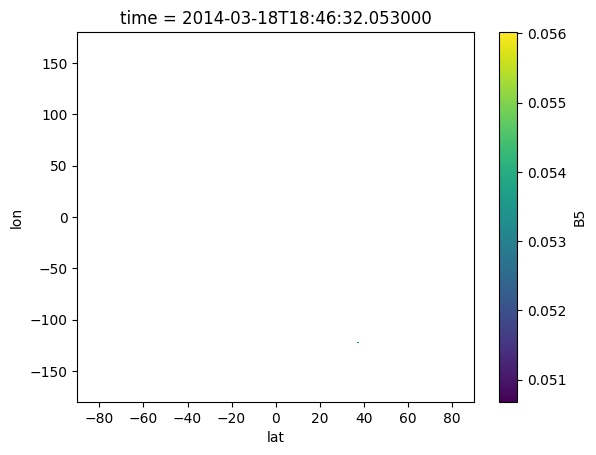

In [77]:
ds.B5[:,:].plot()

Open multiple ImageCollections into one xarray.Dataset, all with the same projection. This one may take a few minutes to load.

In [9]:
ds = geemap.ee_to_xarray(
    dataset=["ECMWF/ERA5_LAND/HOURLY", "NASA/GDDP-CMIP6"],
    n_images=100,
    crs="EPSG:4326",
    scale=0.25,
)
ds

<xarray.Dataset>
Dimensions:                                                       (time: 196,
                                                                   lon: 1440,
                                                                   lat: 720)
Coordinates:
  * time                                                          (time) datetime64[ns] ...
  * lon                                                           (lon) float64 ...
  * lat                                                           (lat) float64 ...
Data variables: (12/78)
    dewpoint_temperature_2m                                       (time, lon, lat) float32 dask.array<chunksize=(49, 512, 256), meta=np.ndarray>
    temperature_2m                                                (time, lon, lat) float32 dask.array<chunksize=(49, 512, 256), meta=np.ndarray>
    skin_temperature                                              (time, lon, lat) float32 dask.array<chunksize=(49, 512, 256), meta=np.ndarray>
    soil_temperature_level_1                                      (time, lon, lat) float32 dask.array<chunksize=(49, 512, 256), meta=np.ndarray>
    soil_temperature_level_2                                      (time, lon, lat) float32 dask.array<chunksize=(49, 512, 256), meta=np.ndarray>
    soil_temperature_level_3                                      (time, lon, lat) float32 dask.array<chunksize=(49, 512, 256), meta=np.ndarray>
    ...                                                            ...
    rlds                                                          (time, lon, lat) float32 dask.array<chunksize=(144, 512, 512), meta=np.ndarray>
    rsds                                                          (time, lon, lat) float32 dask.array<chunksize=(144, 512, 512), meta=np.ndarray>
    sfcWind                                                       (time, lon, lat) float32 dask.array<chunksize=(144, 512, 512), meta=np.ndarray>
    tas                                                           (time, lon, lat) float32 dask.array<chunksize=(144, 512, 512), meta=np.ndarray>
    tasmax                                                        (time, lon, lat) float32 dask.array<chunksize=(144, 512, 512), meta=np.ndarray>
    tasmin                                                        (time, lon, lat) float32 dask.array<chunksize=(144, 512, 512), meta=np.ndarray>
Attributes: (12/33)
    date_range:               [347155200000, 1640649600000]
    description:              <p>ERA5-Land is a reanalysis dataset providing ...
    keywords:                 ['cds', 'climate', 'copernicus', 'ecmwf', 'era5...
    period:                   0
    product_tags:             ['temperature', 'lakes', 'snow', 'soil_water', ...
    provider:                 Climate Data Store
    ...                       ...
    visualization_3_bands:    u_component_of_wind_10m
    visualization_3_max:      30.0
    visualization_3_min:      0.0
    visualization_3_name:     u-component of wind at 10m
    visualization_3_palette:  #FFFFFF,#FFFF71,#DEFF00,#9EFF00,#77B038,#007E55...
    crs:                      EPSG:4326